# Challenge : predict conversions

## Import libraries

In [105]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display


## Read file with labels

In [106]:
# download the csv file
data = pd.read_csv('conversion_data_train.csv')

# give the size of the dataset
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [107]:
# overview of the dataset
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## PART 1 - Explore dataset

In [108]:
# Sample of the dataset before exploration in order to facilitate it
data_sample = data.sample(10000)

A- Description dataset

In [109]:
data_sample.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.00000,10000,10000.000000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5615,NaN,NaN,4879,NaN,NaN
mean,NaN,30.663800,0.68580,NaN,4.880400,0.034400
std,NaN,8.246925,0.46422,NaN,3.401772,0.182263
min,NaN,17.000000,0.00000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.00000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.00000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.00000,NaN,6.000000,0.000000


No missing values but some outliers regarding the features "age" and "total_pages_visited"

B- Outliers

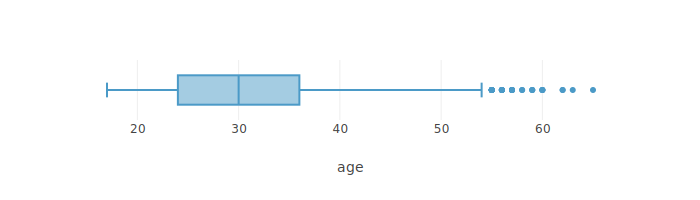

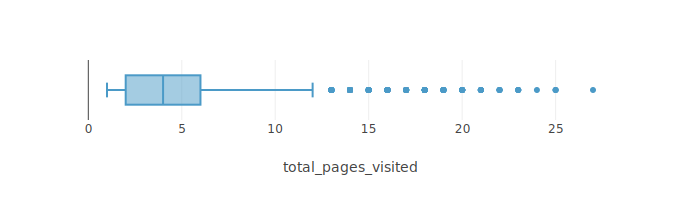

In [110]:
# checking the outliers more precisely for these two columns
fig = px.box(data_sample, x='age', height=200)
fig.show()
fig = px.box(data_sample, x='total_pages_visited', height=200)
fig.show()

The significant size of the global dataset allows us to cancel rows with outliers

In [111]:
# create two masks in order to filter the original dataset
# we will remove values for columns age and total_pages_visited when they are > mean + 3 * standard deviation
mask1 = data["age"] <= (data["age"].mean() + 3 * data["age"].std())
mask2 = data["total_pages_visited"] <= (data["total_pages_visited"].mean() + 3 * data["total_pages_visited"].std())
data_clean = data.loc[mask1 & mask2, :]

In [112]:
print("{} rows have been removed from the original dataset.".format(data.shape[0]-data_clean.shape[0]))

6131 rows have been removed from the original dataset.


C- Types of data

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


Confirmation that there is no missing values. Two variables are string and four variables are integers

D- Univariate analysis

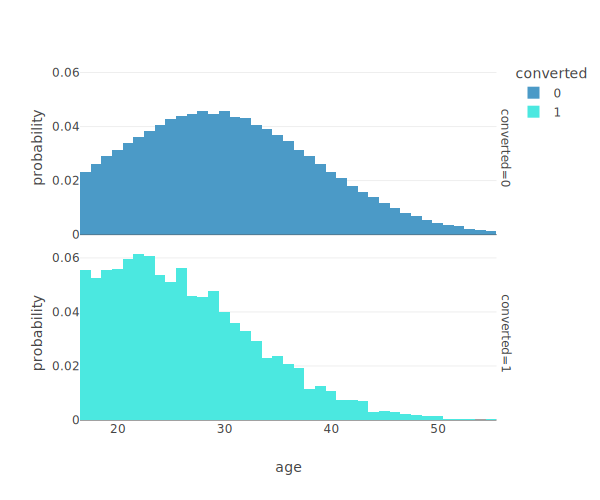

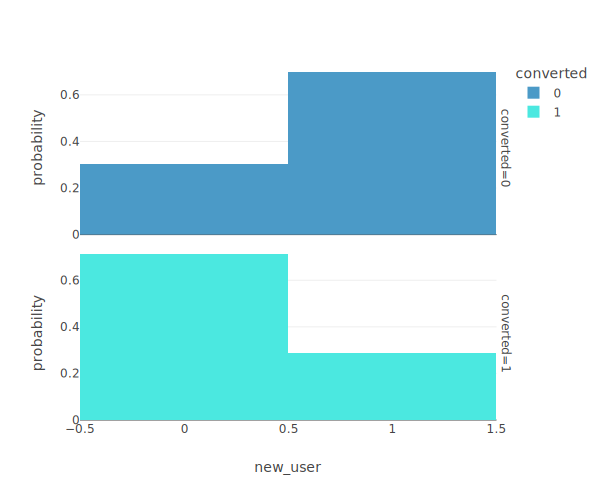

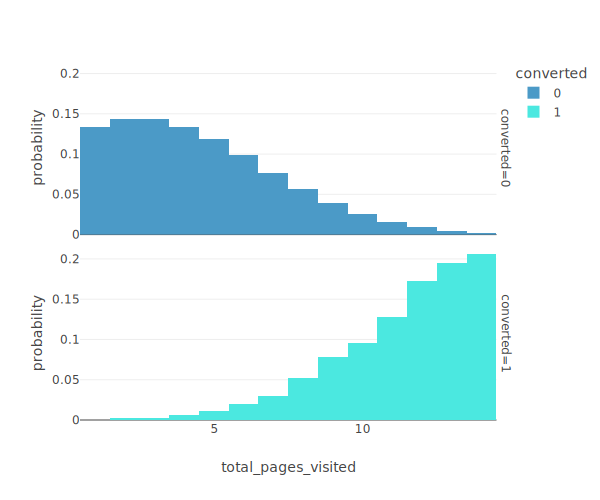

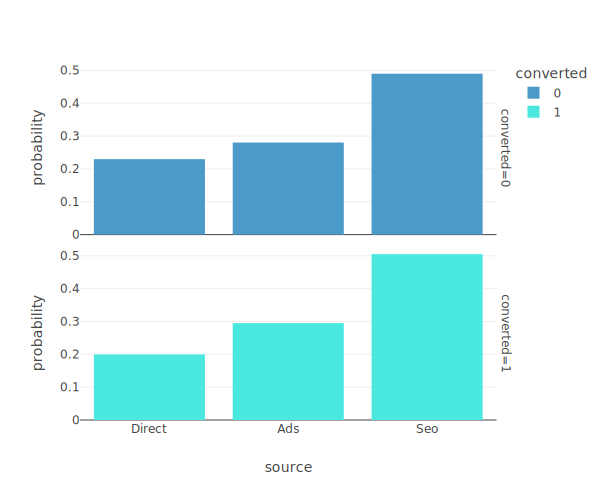

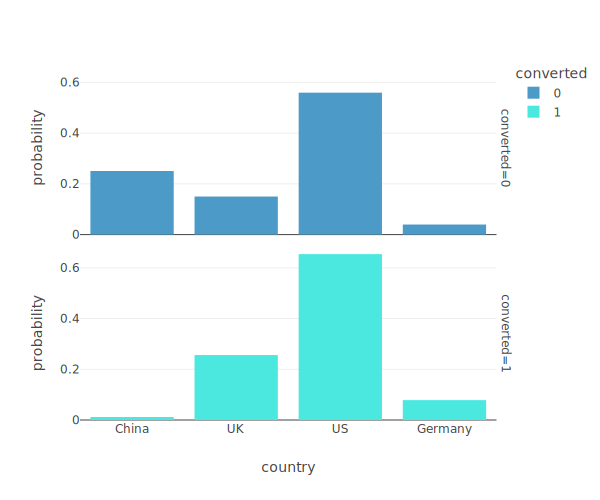

In [114]:
# for each features, visualization of distribution according to the target (converted)
# the comparison of the distribution can help us to detect a correlation
for variable in ["age", "new_user", "total_pages_visited","source","country"] :
    fig = px.histogram(data_clean, x=variable, color = "converted", width=600, facet_row="converted", histnorm="probability")
    fig.show()

we can conclude that :
- the number of pages visited is a good indicator of conversion or not, the greater the number of pages visited, the more likely conversion is
- the notion of customer is also quite discriminatory, converted people being rather new users
- age seems to be a less discriminating criterion even if we note that the converts are generally rather young
- the "country" variable is not very discriminating. there is no real difference between converted or not depending on origin except for the Chinese
- the notion of source does not provide any element in detection

E- Distribution of the target variable

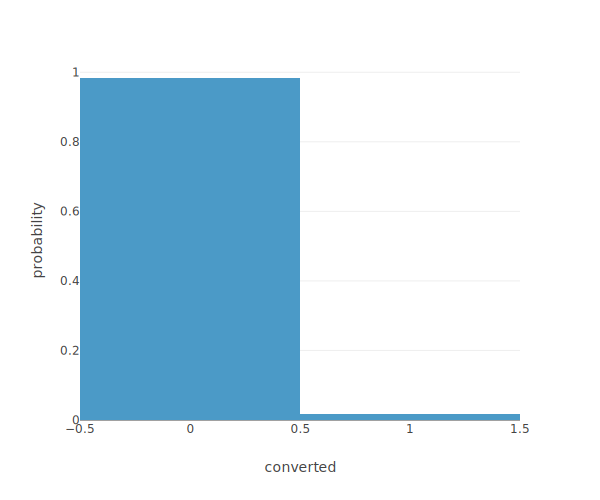

In [115]:
fig = px.histogram(data_clean, x="converted", width=600, histnorm="probability")
fig.show()

** The distribution of the target variable is very unbalanced. \
So, the accuracy score won't be a good way to assess the performance of our model. Indeed, with this kind of score, a dummy model predicting always a no conversion will have a good score.

## PART 2 - MULTIVARIATE LOGISTIC REGRESSION WITH GLOBAL DATASET

We first used the global dataset without removing outliers as we have seen just above

In [116]:
# data selection
target_variable = "converted"
X = data.iloc[:,:-1]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [117]:
# size of features set and tagret set
X.shape, Y.shape

((284580, 5), (284580,))

In [118]:
# Divide dataset Train set with 80% of data and Test set the remaining
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y) # stratify helps to ensure that the train and test sets have the same proportion of class labels as the input dataset
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [119]:
# size of features dataset for train and test set
X_train.shape, X_test.shape

((227664, 5), (56916, 5))

In [120]:
X_train

,country,age,new_user,source,total_pages_visited
137434,China,19,1,Seo,1
112323,US,33,1,Direct,5
143261,US,51,1,Ads,2
162328,China,17,0,Seo,1
158039,China,28,1,Seo,5
...,...,...,...,...,...
132514,US,29,0,Seo,15
243326,China,45,0,Seo,3
136997,US,31,0,Ads,1
70286,UK,27,0,Ads,9


#### A- Training pipeline

In [121]:
# set preprocessing for categorical features
cat_features = ["country", "new_user","source"]
cat_transformer = OneHotEncoder(drop="first")

# set preprocessing for numerical features
num_features = ["age","total_pages_visited"]
num_transformer = StandardScaler()

# combine the two kinds of preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer,num_features),
    ("cat", cat_transformer, cat_features)
])

In [122]:
# apply preprocessing to features train set
print("Starting preprocessing on train set .....")
X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5])

Starting preprocessing on train set .....
...Done
[[-1.3990984  -1.15935344  0.          0.          0.          1.
   0.          1.        ]
 [ 0.29299544  0.03743241  0.          0.          1.          1.
   1.          0.        ]
 [ 2.46854467 -0.86015697  0.          0.          1.          1.
   0.          0.        ]
 [-1.64082609 -1.15935344  0.          0.          0.          0.
   0.          1.        ]
 [-0.31132378  0.03743241  0.          0.          0.          1.
   0.          1.        ]]


In [123]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [124]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



#### B- Test pipeline

In [125]:
# apply preprocessing on features test set
print("Encoding categorical features and standardizing numerical features...")
X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.41385929 -1.15935344  0.          1.          0.          1.
   0.          0.        ]
 [ 0.1721316   0.03743241  0.          1.          0.          0.
   0.          0.        ]
 [ 1.62249775 -1.15935344  0.          0.          1.          1.
   0.          0.        ]
 [ 0.53472314 -1.15935344  0.          0.          1.          1.
   1.          0.        ]
 [-0.19045994 -0.56096051  0.          0.          1.          1.
   1.          0.        ]]


In [126]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



#### C- Performance assessment

In [127]:
# As explain, the f1-score will be used to assess the performances
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred).round(4))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred).round(4))

f1-score on train set :  0.7655
f1-score on test set :  0.7554


Performances are quite close on the two datasets.

In [128]:
# Creation of a summary table of results by model
model_results = pd.DataFrame.from_dict({
    "Model" :["Multivariate Logistic_regression"] ,
    "Train_set" : [f1_score(Y_train, Y_train_pred).round(3)],
    "Test_set" : [f1_score(Y_test, Y_test_pred).round(3)]
    })
model_results

,Model,Train_set,Test_set
0,Multivariate Logistic_regression,0.765,0.755


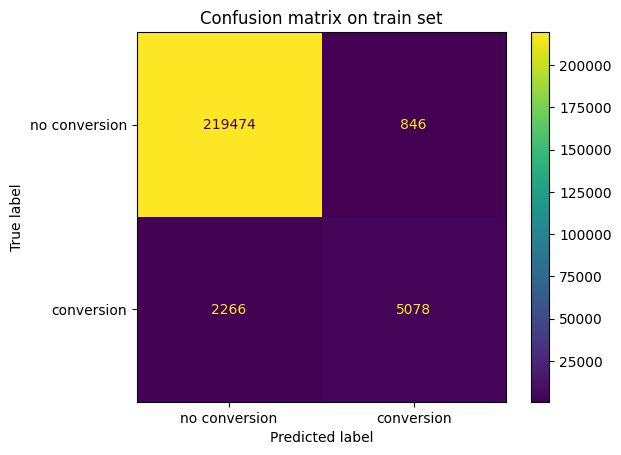

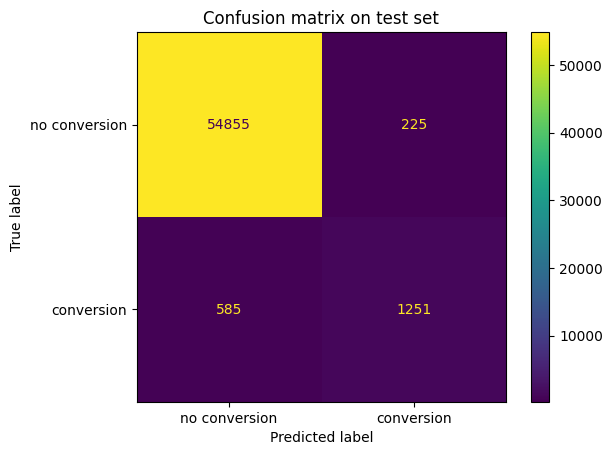

In [129]:
# We also check performance through the Confusion matrix for tran and test set
_,ax = plt.subplots()
ax.set(title="Confusion matrix on train set")
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax, display_labels=["no conversion","conversion"])
plt.show()

_,ax = plt.subplots()
ax.set(title="Confusion matrix on test set")
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax, display_labels=["no conversion","conversion"])
plt.show()

Our baseline model reaches a f1-score of almost 76% which is not very high. Our model has some difficulties to detect conversion, doing a lot of mistakes.

Indeed, according to the matrix confusion on test set above, 227 conversion were predicted but in fact there were not (on a total of 1250+227 conversion prediction )

#### D- Regularisation and Hyperparameters optimisation

In [130]:
# we used gridsearch with different values of the parameter C (penalty) and a cross validation of 10
#we set the number of iteration to 1000 (max_iter) and we'll adjust later if needed
classifier = LogisticRegression(max_iter=1000)

# we used three hyperparameters
# c = inverse of regularization strength
# solver = algorithm to use in the optimization problem
# penalty = specify the norm of the penalty
params = {
    "C" : [0.01, 0.1, 0.25, 0.4, 0.6, 0.8],
    "solver" : ["liblinear","newton-cholesky","lbfgs","newton-cg","sag","saga"],
    "penalty" : ["l2","l1","elasticnet"]
}

# we retain a number of 10 cross validation
grid = GridSearchCV(classifier, param_grid = params, scoring = "f1", cv=10)
grid.fit(X_train, Y_train)

C:\Users\SD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


600 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\SD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\SD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 0.25, 0.4, 0.6, 0.8],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'solver': ['liblinear', 'newton-cholesky', 'lbfgs',
                                    'newton-cg', 'sag', 'saga']},
             scoring='f1')

In [131]:
# Predictions
Y_train_pred = grid.predict(X_train)
Y_test_pred = grid.predict(X_test)

In [132]:
# performance assessment
print("Best parameter : ", grid.best_params_)
print("Best F1 score :", f1_score(Y_train, Y_train_pred).round(4))
print("F1 score on test set :", f1_score(Y_test, Y_test_pred).round(4))

Best parameter :  {'C': 0.4, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score : 0.7655
F1 score on test set : 0.7554


Results aren't improved with this optimization.

In [133]:
encoded_cols = list(preprocessor.get_feature_names_out(X.columns))

In [134]:
# Analysis of feature importance
features_analysis = pd.DataFrame(index=encoded_cols, data = grid.best_estimator_.coef_.transpose(), columns=["Coefs"])
features_analysis

,Coefs
num__age,-0.592212
num__total_pages_visited,2.545130
cat__country_Germany,3.571637
cat__country_UK,3.417610
cat__country_US,3.044669
cat__new_user_1,-1.687117
cat__source_Direct,-0.190018
cat__source_Seo,-0.039523


As seen before, age isn't a discriminant variable.

In [135]:
# add result to the summary table
result = pd.DataFrame([["Optimised_Logistic_regression",f1_score(Y_train, Y_train_pred).round(3),f1_score(Y_test, Y_test_pred).round(3)]], columns=['Model','Train_set','Test_set'])

In [136]:
model_results = pd.concat([model_results, result], ignore_index=True)
model_results

,Model,Train_set,Test_set
0,Multivariate Logistic_regression,0.765,0.755
1,Optimised_Logistic_regression,0.766,0.755


#### H- Univariate model

In [137]:
# our analysis of the variables showed that correlations between explanatory variables and the target variable were very light,
# a part from the "total_pages_visited" used in the baseline model with one feature
# we propose so to try a logisistic regression with only one variable, the main one ("total_pages_visited")

# Selection des données
X = data.loc[:,["total_pages_visited"]]
Y = data.loc[:, "converted"]
X.head()

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train_univ, X_test_univ, Y_train_univ, Y_test_univ = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

# preprocessing
num_features = ["total_pages_visited"]
num_transformer = StandardScaler()

print("début du preprocessing sur le jeu d'entrainement :")
X_train_univ = num_transformer.fit_transform(X_train_univ)
print("...Done")
print("Encoding categorical features and standardizing numerical features...")
X_test_univ = num_transformer.transform(X_test_univ)
print("...Done")

# Train model
print("Train model...")
classifier_univariate = LogisticRegression(max_iter=1000)
classifier_univariate.fit(X_train_univ, Y_train_univ)
print("...Done.")

# Predictions
print("Predictions on training set...")
Y_train_pred = classifier_univariate.predict(X_train_univ)
print("...Done.")
print("Predictions on training set...")
Y_test_pred = classifier_univariate.predict(X_test_univ)
print("...Done.")

# Performance assessment
print("f1-score on train set : ", f1_score(Y_train_univ, Y_train_pred).round(4))
print("f1-score on test set : ", f1_score(Y_test_univ, Y_test_pred).round(4))

Dividing into train and test sets...
...Done.

début du preprocessing sur le jeu d'entrainement :
...Done
Encoding categorical features and standardizing numerical features...
...Done
Train model...
...Done.
Predictions on training set...
...Done.
Predictions on training set...
...Done.
f1-score on train set :  0.6971
f1-score on test set :  0.6772


The performance of the model is significantly less good with only one feature.

#### I - Multivariate model with clean dataset without outliers

In [158]:
# our analysis of the variables showed that correlations between explanatory variables and the target variable were very light,
# a part from the "total_pages_visited" used in the baseline model with one feature
# we propose so to try a logisistic regression with only one variable, the main one ("total_pages_visited")

# data selection
target_variable = "converted"
X = data_clean.iloc[:,:-1]
Y = data_clean.loc[:, target_variable]

# Divide dataset Train set & Test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)

# preprocessing
# set preprocessing for categorical features
cat_features = ["country", "new_user","source"]
cat_transformer = OneHotEncoder(drop="first")
# set preprocessing for numerical features
num_features = ["age","total_pages_visited"]
num_transformer = StandardScaler()
# combine the two kinds of preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer,num_features),
    ("cat", cat_transformer, cat_features)
])

# apply preprocessing to features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

# Train model
classifier_clean = LogisticRegression(max_iter=1000)
classifier_clean.fit(X_train, Y_train)

# Predictions
Y_train_pred = classifier_clean.predict(X_train)
Y_test_pred = classifier_clean.predict(X_test)

# Performance assessment
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred).round(4))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred).round(4))

f1-score on train set :  0.5077
f1-score on test set :  0.4767


Performance are widely less significant.

## PART 3 - RANDOM FOREST WITH OPTIMISATION

#### A- Train model

In [139]:
print("Starting Grid Search ......")
random_forest = RandomForestClassifier()

# we chose various values for a selection of hyperparameters
# max_depth = maximum depth of the tree
# min_sample_leaf = minimum number of samples required to be at a leaf node
# min_samples_split = minimum number of samples required to split an internal node
# n_esimators = number of trees in the forest
params = {
    "max_depth" : [5,8,10],
    "min_samples_leaf" : [1,2,5,6],
    "min_samples_split" : [2,4,6],
    "n_estimators" : [10,20,40,60,80]
}

# train the model with gridsearch cv and 3 validations
# we retain F1_score to measure performance
grid_random = GridSearchCV(random_forest, param_grid=params, scoring="f1", cv=3, n_jobs=-1)
grid_random.fit(X_train, Y_train)
print("......Done.")

Starting Grid Search ......
......Done.


In [140]:
print("Best parameters : ", grid_random.best_params_)

Best parameters :  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 20}


In [141]:
# Predictions on train and test set
print("Predictions on training set...")
Y_train_pred = grid_random.predict(X_train)
print("...Done.")
print("Predictions on test set...")
Y_test_pred = grid_random.predict(X_test)
print("...Done.")

Predictions on training set...


...Done.
Predictions on test set...
...Done.


#### B- Performance assessment

In [142]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred).round(4))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred).round(4))

f1-score on train set :  0.5383
f1-score on test set :  0.4912


In [143]:
# Enrichissement du tableau de synthèse
result = pd.DataFrame([["Optimised_Random_forest",f1_score(Y_train, Y_train_pred).round(3),f1_score(Y_test, Y_test_pred).round(3)]], columns=['Model','Train_set','Test_set'])
model_results = pd.concat([model_results,result], ignore_index=True)
model_results

,Model,Train_set,Test_set
0,Multivariate Logistic_regression,0.765,0.755
1,Optimised_Logistic_regression,0.766,0.755
2,Optimised_Random_forest,0.538,0.491


There is no really improvment in the performance at this point.

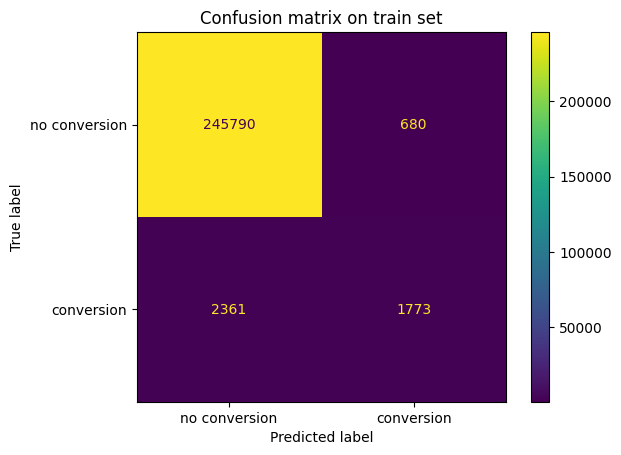

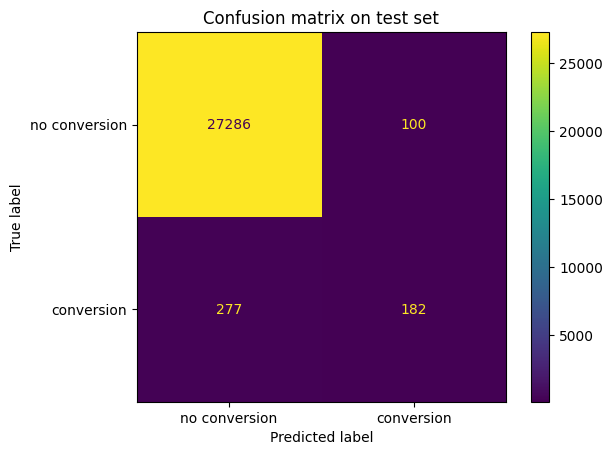

In [148]:
# We also check performance through the Confusion matrix
_,ax = plt.subplots()
ax.set(title="Confusion matrix on train set")
ConfusionMatrixDisplay.from_estimator(grid_random, X_train, Y_train, ax=ax, display_labels=["no conversion","conversion"])
plt.show()

_,ax = plt.subplots()
ax.set(title="Confusion matrix on test set")
ConfusionMatrixDisplay.from_estimator(grid_random, X_test, Y_test, ax=ax, display_labels=["no conversion","conversion"])
plt.show()

## PART 4 - Train best classifier on all data and use it to make predictions on X_without_labels
Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [159]:
# Concatenate our train and test set to train your best classifier on all data with labels
X_global = np.append(X_train,X_test,axis=0)
Y_global = np.append(Y_train,Y_test)

# use the first model that gives the best results
classifier.fit(X_global,Y_global)

LogisticRegression(max_iter=1000)

In [160]:
# Read data without labels
X_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', X_without_labels.shape)

X_without_labels.head()

Prediction set (without labels) : (31620, 5)


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [161]:
print("Encoding categorical features and standardizing numerical features...")

# preprocess features
X_without_labels_prep = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels_prep[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30718036  3.95417859  0.          1.          0.          0.
   0.          1.        ]
 [-1.04537291  0.12356222  0.          1.          0.          1.
   1.          0.        ]
 [ 0.18494801 -1.26938919  0.          0.          0.          1.
   0.          1.        ]
 [ 0.18494801  0.47180007  0.          0.          1.          1.
   0.          0.        ]
 [-0.67627663 -0.57291348  0.          0.          0.          0.
   0.          1.        ]]


In [162]:
# see size of the dataset
X_without_labels_prep.shape

(31620, 8)

Instructions :
- Make predictions and dump to file
- WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
- WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
- where [name] is the name of your team/model separated by a '-'
- For example : [name] = AURELIE-model1

In [163]:
# make predictions and put it on a dictionary
data = {
    'converted': classifier.predict(X_without_labels_prep)
}

# transform distionary into dataframe
Y_predictions = pd.DataFrame(columns=['converted'],data=data)

# save dataframe to a csv file
Y_predictions.to_csv('conversion_data_test_predictions_DuplandSylvain-model1.csv', index=False)

In [164]:
Y_predictions.value_counts() / Y_predictions.shape[0] * 100

converted
0            97.390892
1             2.609108
Name: count, dtype: float64

The conversion rate is estimated at around 2,6% on this new dataset.

In [167]:
# Analyse des coefficients affectés à chaque variables explicatives
encoded_cols = list(preprocessor.get_feature_names_out(X_without_labels.columns))
coefs = pd.DataFrame(index=encoded_cols, data = classifier.coef_.transpose(), columns=["Coefficients"])
coefs = abs(coefs).sort_values(by="Coefficients", ascending=False)

In [168]:
coefs

,Coefficients
cat__country_Germany,3.523879
cat__country_UK,3.371646
cat__country_US,3.007002
num__total_pages_visited,2.175859
cat__new_user_1,1.717968
num__age,0.600611
cat__source_Direct,0.211001
cat__source_Seo,0.005732


As expected, source and age aren't explicative variables.

## Part - 6 Conclusions

At least, the logistic regression model with all the features gives the best results at a first look.

In order to improve the model performance, we could try to get new features linked to the customer profile.

For example the kind of pages visited (subjects), or the time stayed on the website.

We could also try with a xgboost model but i'm not sure that results will be really better.